## IMPORTS

In [7]:
# import tensorflow + keras
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from PIL import Image
from skimage import transform
from sklearn.model_selection import KFold
import cv2 as cv
import os
import itertools

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## HyperHyperParameters

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_FOLD = 10

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## CrossValidation

In [5]:
# kfold.split(inputs, targets)
def create_dataset(img_folder,normalize=False):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv.imread( image_path, cv.COLOR_BGR2RGB)
            image=cv.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            if(normalize):
                image /= 255 
            img_data_array.append(image)
            # I was too lazy and that's ugly dont do it this way !
            class_name.append(dir1)

    return img_data_array, class_name# extract the image array and class name

In [6]:
train_data, train_gt =create_dataset("dataset/train_images/")

In [24]:
target_dict={k: v for v, k in enumerate(np.unique(train_gt))}
target_val=  [target_dict[train_gt[i]] for i in range(len(train_gt))]

{'fields': 0, 'roads': 1}

## Hyperparameters

In [52]:
logdir="../trimble/log"
BATCH_SIZE = 16
#EPOCHS = 20
learning_rate = 0.001

## Dataset

In [30]:
# Data generation for training, we do a data augmentation 
train_datagen = ImageDataGenerator(
    # rescale = 1./255., 
    rotation_range = 30, 
    width_shift_range = 10,
    height_shift_range = 10,
    zoom_range = [1,1.05],
    validation_split=0.2,
    brightness_range=[0.5,1.3],
    horizontal_flip = True)

test_datagen = ImageDataGenerator( 
    # rescale = 1.0/255. 
    )
dataset_folder = "dataset"
# Creating iterator with the generator, with the the specified directory
train_iterator = train_datagen.flow_from_directory(
    directory=dataset_folder+"/train_images/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset="training"
)

val_iterator = train_datagen.flow_from_directory(
    directory=dataset_folder+"/train_images/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    subset="validation",
    seed=42,
)

test_iterator = test_datagen.flow_from_directory(
    directory=dataset_folder+"/test_images/",
    
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42
)

Found 122 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


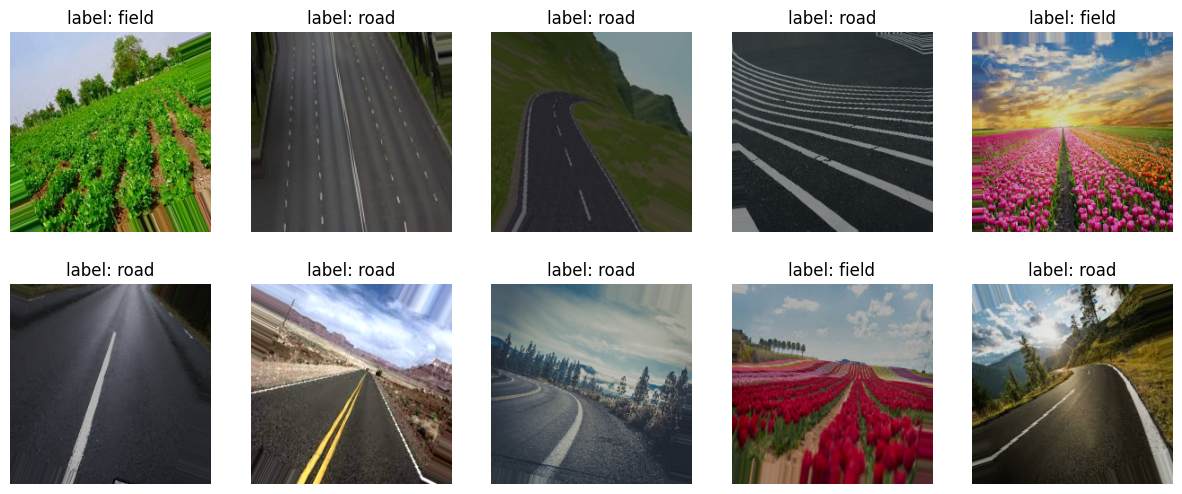

In [31]:
class_names = ['field','road']
image ,label = next(iter(train_iterator))
fig, axes = plt.subplots(2,5,figsize=(15,6))
for idx, axe in enumerate(axes.flatten()):
    axe.axis('off')
    axe.imshow(image[idx].astype(int))
    axe.set_title(f'label: {class_names[int(label[idx])]}')

In [53]:
## Backbone Model creation
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
base_model.trainable = False

def create_model(parameters):
    epochs,lr,opt,rate = parameters
    ## Building our model

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dropout(rate=rate),
        layers.Dense(1,activation="sigmoid")
    ])

    ## we compute the number of steps for training and validation
    metrics = ["accuracy"]
        
    if(opt=="lion"):
        optimizer = tf.keras.optimizers.Lion(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.get(opt)
        optimizer.lr.assign(lr)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=metrics) 
    return model

In [121]:
kfold = KFold(n_splits=NUM_FOLD, shuffle=True)
# np.random.seed(100)
train_data = np.array(train_data)
# np.random.shuffle(train_data)
target_val = np.array(target_val)
# np.random.shuffle(train_data)
fold_split = kfold.split(train_data, target_val)    
for train, val in fold_split:
    print(train)

[  0   1   2   3   5   6   7   9  10  11  13  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38  39  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  92  95  96  97  98  99 100
 101 102 103 104 105 106 107 110 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 136 137 138 139 140
 141 142 143 144 145 146 147 148 149]
[  0   1   2   3   4   5   6   7   8   9  11  12  13  14  16  17  18  19
  20  21  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  86  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 

## Parameters to test

In [54]:
epochs_cv = [10,15,20,25]
lr_cv = [1e-4,1e-5,1e-6,1e-7]
#lr_decay_cv = [True,False]
optimizer_cv = ["lion","rmsprop"]
dropout_cv = [0.0,0.2,0.4,0.6,0.8]
all_possible_parms = list(itertools.product(*[epochs_cv,lr_cv,optimizer_cv,dropout_cv]))

## Model Training and Validation

In [70]:
models_results = []

steps_per_epoch=len(train_data)/BATCH_SIZE

kfold = KFold(n_splits=NUM_FOLD, shuffle=True)
train_data = np.array(train_data)
target_val = np.array(target_val)
fold_split = kfold.split(train_data, target_val)    

for params in all_possible_parms:
    model = create_model(params)
    current_model_accs = []
    current_model_losses = []
    print('#######################################')
    print('WITH THESE PARAMETERS -----------------')
    print('---------------------------------------')
    print(f"Epochs : {params[0]}, LR : {params[1]} , OPT:{params[2]}, DROPOUT : {params[3]}")
    fold_no = 1
    for train, val in fold_split:
        history = model.fit(train_data[train],
                target_val[train],
                batch_size = BATCH_SIZE , 
                epochs = params[0] ,
                steps_per_epoch = steps_per_epoch ,
                verbose = 1)
        
        scores = model.evaluate(train_data[val], target_val[val], verbose=0)
        current_model_accs.append(scores[1]*100)
        current_model_losses.append(scores[0])
        print(f'FOLD {fold_no} >>> LOSS {scores[0]} ---- ACCURACY {scores[1]*100} <<<')
        fold_no +=1

    cm_acc = np.mean(current_model_accs)
    cm_loss = np.mean(current_model_losses)
    
    print('---------------------------------------')
    print('WITH THESE PARAMETERS -----------------')
    print('---------------------------------------')
    print(f"Epochs : {params[0]}, LR : {params[1]} , OPT:{params[2]}, DROPOUT : {params[3]}")
    print('---------------------------------------')
    print(f'LOSS ==>  {cm_loss}  <==')
    print('---------------------------------------')
    print(f'ACCURACY ==>  {cm_acc}  <==')
    print('---------------------------------------')
    print('#######################################')
    
    models_results.append([cm_acc,cm_loss])

#######################################
WITH THESE PARAMETERS -----------------
---------------------------------------
Epochs : 10, LR : 0.0001 , OPT:lion, DROPOUT : 0.0
[  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  28  29  30  31  32  34  35  36  37  38
  39  40  42  43  44  45  46  47  48  50  51  52  54  55  56  57  58  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 129 130 132 133 134 136 137
 139 141 142 143 144 145 146 148 149]


AttributeError: 'NoneType' object has no attribute 'fit'

In [127]:
#my_model.save("my_model.keras")

## Plotting curves

In [ ]:
plt.plot(history.epoch, history.history["accuracy"], 'g', label='Training accuracy')
plt.plot(history.epoch, history.history["val_accuracy"], 'b', label='Validation accuracy')
plt.title('Accuracy evolution')
plt.xlabel('accuracy')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'b', label='Validation loss')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Evaluation

In [164]:
results = my_model.evaluate(test_iterator, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

1/1 [==============================] - 1s 659ms/step - loss: 0.6534 - accuracy: 0.7000
test loss, test acc: [0.6533956527709961, 0.699999988079071]


1/1 [==============================] - 3s 3s/step


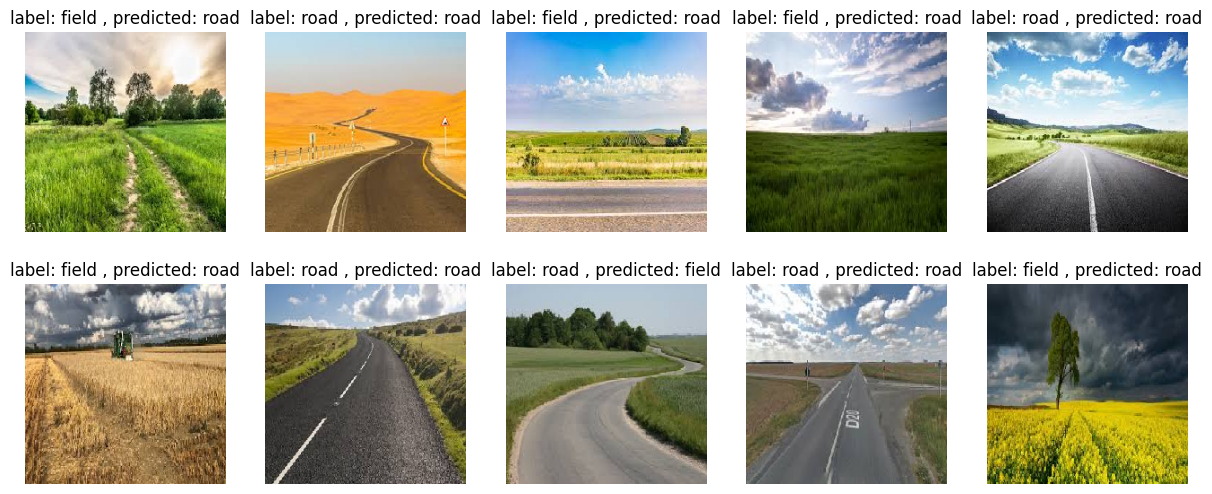

In [140]:
# Prediction output, we show prediction result and ground truth value
predictions = np.round(my_model.predict(test_iterator))
class_names = ['field','road']
image ,label = next(iter(test_iterator))
fig, axes = plt.subplots(2,5,figsize=(15,6))
for idx, axe in enumerate(axes.flatten()):
    axe.axis('off')
    axe.imshow(image[idx].astype(int))
    axe.set_title(f'label: {class_names[int(label[idx])]} , predicted: {class_names[int(predictions[idx])]}')

## Prediction on new data

In [73]:
filename = "newdata.jpeg"
image = Image.open(filename)
image = np.array(image).astype('float32')
image = transform.resize(image, (224, 224, 3))
image = np.expand_dims(image, axis=0)
np.round(my_model.predict(image))

1/1 [==============================] - 0s 83ms/step


array([[1.]], dtype=float32)